In [48]:
import sys
import os
import torchvision
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torcheval.metrics import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassRecall,
    MulticlassPrecision,
    MulticlassConfusionMatrix,
)

In [49]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(
            3, 6, 5
        )  # (3, 256, 256) -> new dim (256 - 5 + (2 * 0)) / 1 + 1 ) = 252 (6, 252, 252)
        self.pool = nn.MaxPool2d(2, 2)  # (6, 252, 252) -> (6, 126, 126)
        self.conv2 = nn.Conv2d(
            6, 16, 5
        )  # (6, 126, 126) -> (16, 122, 122) -> MaxPool -> (16, 61, 61)
        # self.fc1 = nn.Linear(16 * 61 * 61, 2048)
        self.fc1 = nn.Linear(16 * 13 * 13, 1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [50]:
def create_dataloaders(dataset):
    # data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    data_loader = DataLoader(dataset, shuffle=True)
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    # print(images, labels)
    print(dataset.classes)
    # imshow(torchvision.utils.make_grid(images))
    labels = np.array([dataset.targets[i] for i in range(len(dataset))])

    # Define split sizes
    train_size = 0.7  # 70% for training
    val_size = 0.15  # 15% for validation
    test_size = 0.15  # 15% for testing

    # First, split into train + temp (val + test)
    train_idx, temp_idx, _, temp_labels = train_test_split(
        np.arange(len(dataset)),
        labels,
        stratify=labels,
        test_size=(1 - train_size),
        random_state=42,
    )

    # Then, split temp into validation and test
    val_idx, test_idx = train_test_split(
        temp_idx,
        stratify=temp_labels,
        test_size=(test_size / (test_size + val_size)),
        random_state=42,
    )

    # Create samplers
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    # Create DataLoaders
    train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)
    # test_loader = DataLoader(dataset, batch_size=32, sampler=test_sampler)
    test_loader = DataLoader(dataset, sampler=test_sampler)
    return train_loader, val_loader, test_loader


def load_dataset(directory_path):
    transform = transforms.Compose(
        [
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    dataset = torchvision.datasets.ImageFolder(root=directory_path, transform=transform)
    return dataset

In [51]:
# dataset = load_dataset("~/sgoinfre/leaves/images/Apple")
dataset = load_dataset("~/sgoinfre/leaves/augmented_dataset/Apple")
train_loader, val_loader, test_loader = create_dataloaders(dataset)

['Apple_Black_rot', 'Apple_healthy', 'Apple_rust', 'Apple_scab']


In [52]:
def compute_validation_metrics(net, validation_loader):
    net.eval()
    criterion = nn.CrossEntropyLoss()

    validation_metrics = {"loss": 0}
    with torch.no_grad():
        f1_score = MulticlassF1Score(num_classes=4, average="macro")
        for inputs, labels in validation_loader:
            outputs = net(inputs)
            preds = torch.argmax(outputs, dim=1)

            loss = criterion(outputs, labels)
            validation_metrics["loss"] += loss.item()
            f1_score.update(preds, labels)
    validation_metrics["loss"] /= len(validation_loader)
    validation_metrics["f1_score"] = f1_score.compute()
    net.train()
    return validation_metrics


def update_validation_metrics_history(
    net, validation_loader, validation_metrics_history
):
    new_validation_metrics = compute_validation_metrics(net, validation_loader)
    for name, value in new_validation_metrics.items():
        validation_metrics_history[name].append(value)

In [53]:
def early_stop(state_dict, validation_loss, best_loss=None, counter=0, patience=5, min_delta=0):
    if best_loss is None:
        best_loss = validation_loss
    elif validation_loss < best_loss - min_delta:
        best_loss = validation_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            torch.save(state_dict, "best_model.pth")
            return True, best_loss, counter
    return False, best_loss, counter


In [54]:
def train_model(train_loader, validation_loader):
    net = CNN()
    criterion = nn.CrossEntropyLoss()
    best_loss = None
    counter = 0
    patience = 10
    optimizer = optim.AdamW(net.parameters(), lr=0.001, weight_decay=0.001)
    validation_metrics_history = {"f1_score": [], "loss": [], "accuracy": []}
    train_metrics_history = {"f1_score": [], "loss": [], "accuracy": []}
    for epoch in range(100):

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            print(i)
        train_metrics_history["loss"].append(running_loss / len(train_loader))
        
        update_validation_metrics_history(
            net, validation_loader, validation_metrics_history
        )
        print(validation_metrics_history)
        print(best_loss)
        state_dict = net.state_dict()
        stop, best_loss, counter = early_stop(
            state_dict,
            validation_metrics_history["loss"][-1],
            best_loss=best_loss,
            counter=counter,
            patience=patience,
        )
        if stop:
            return validation_metrics_history, train_metrics_history
        print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")
    torch.save(net.state_dict(), "best_model.pth")
    return validation_metrics_history, train_metrics_history

In [55]:
validation_history, train_history = train_model(train_loader, val_loader)

0
1
2
3
4
5
6
7
8
9
10
11


KeyboardInterrupt: 

[0.4461372393754221, 0.22791799590472253, 0.2166185908980908, 0.20168000363534497, 0.19742648519815936, 0.20684344549813577, 0.2066286406930416, 0.3255294639497034, 0.14171624273782776, 0.2044154416409231, 0.17444719830828329, 0.18872365277380712, 0.16068372529961408, 0.21555142483163264, 0.16224213425190218, 0.18877980668818758, 0.18773177040425398, 0.17375751906224796, 0.15342215657414449]


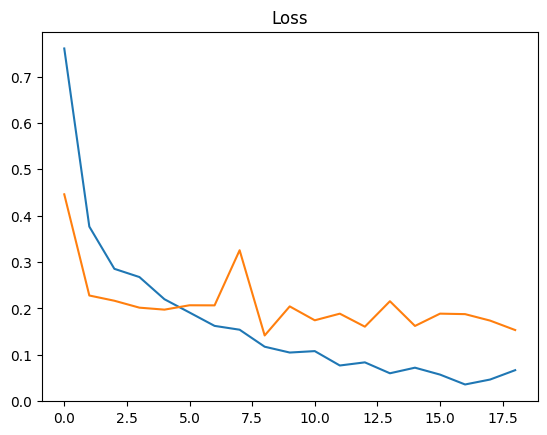

In [ ]:
print(validation_history['loss'])

plot = plt.figure()
plt.plot(train_history['loss'])
plt.plot(validation_history['loss'])
plt.title('Loss')
plt.show()

In [59]:
def test_model(net, test_loader, num_classes):
    net.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = net(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = torch.tensor(all_preds)
    all_labels = torch.tensor(all_labels)

    metrics = {
        "accuracy": MulticlassAccuracy(),
        "recall": MulticlassRecall(num_classes=num_classes, average="macro"),
        "precision": MulticlassPrecision(num_classes=num_classes, average="macro"),
        "f1_score": MulticlassF1Score(num_classes=num_classes, average="macro"),
        "confusion_matrix": MulticlassConfusionMatrix(num_classes=num_classes),
    }

    for metric in metrics.values():
        metric.update(all_preds, all_labels)

    results = {name: metric.compute() for name, metric in metrics.items()}

    for name, value in results.items():
        print(f"Test {name.capitalize()}: {value}")

    # Uncomment the following lines if you want to display the confusion matrix
    # disp = ConfusionMatrixDisplay(results['confusion_matrix'], display_labels=dataset.classes)
    # disp.plot()
    plt.show()

In [60]:
test_net = CNN()
test_net.load_state_dict(torch.load("best_model.pth", weights_only=True))
test_model(test_net, test_loader, len(dataset.classes))

Test Accuracy: 0.9605262875556946
Test Recall: 0.9605262875556946
Test Precision: 0.9605740308761597
Test F1_score: 0.9604570269584656
Test Confusion_matrix: tensor([[232.,   5.,   3.,   7.],
        [  7., 233.,   0.,   7.],
        [  1.,   0., 246.,   0.],
        [  5.,   2.,   2., 238.]])


In [ ]:
from sklearn.metrics import classification_report

def generate_classification_report(net, test_loader, class_names):
    net.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = net(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=class_names)
    print(report)
    print(class_names)

# Assuming `dataset.classes` contains the class names
generate_classification_report(test_net, test_loader, dataset.classes)

                 precision    recall  f1-score   support

Apple_Black_rot       0.95      0.94      0.94       247
  Apple_healthy       0.97      0.94      0.96       247
     Apple_rust       0.98      1.00      0.99       247
     Apple_scab       0.94      0.96      0.95       247

       accuracy                           0.96       988
      macro avg       0.96      0.96      0.96       988
   weighted avg       0.96      0.96      0.96       988

